Resources:

**Convolutional recurrent neural networks:**

https://github.com/bgshih/crnn

paper: https://arxiv.org/pdf/1507.05717.pdf

pytorch implementation:
https://github.com/meijieru/crnn.pytorch


ocr image dataset:
http://iapr-tc11.org/mediawiki/index.php?title=ICDAR_2003_Robust_Reading_Competitions

Recurrence is required to capture the representational
dynamics of the human visual system: 
https://www.pnas.org/doi/pdf/10.1073/pnas.1905544116
https://cbmm.mit.edu/video/its-about-time-modelling-human-visual-inference-deep-recurrent-neural-networks

Other related resources:

Recurrent Attention Models:
https://github.com/kevinzakka/recurrent-visual-attention

https://github.com/Element-Research/rnn/blob/master/examples/recurrent-visual-attention.lua

https://github.com/jlindsey15/RAM

In [1]:
import torch
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import InputLayer, Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.python.keras import backend as K
import math
import pathlib
import datetime
from scipy.io import savemat
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import time

In [2]:
from google.colab import drive 
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Embeddings/rnn'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Embeddings/rnn


# Define CRNN model:

In [102]:
import torch.nn as nn


class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))
        
    # def init_hidden(self,):
    #     return (torch.zeros(512, self.nh, self.nh))

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # self.hidden = self.init_hidden()
        # self.hidden = self.rnn[0](input, self.hidden)  

        # rnn features
        output = self.rnn(conv)

        return output

In [138]:
import torch
from torch.autograd import Variable
# import utils
# import dataset
from PIL import Image


model_path = 'crnn.pth'
img_path = 'demo.png'
alphabet = '0123456789abcdefghijklmnopqrstuvwxyz'

In [139]:
model = CRNN(32, 1, 37, 256)
if torch.cuda.is_available():
    model = model.cuda()
print('loading pretrained model from %s' % model_path)
model.load_state_dict(torch.load(model_path))

loading pretrained model from crnn.pth


<All keys matched successfully>

In [140]:
import torch
import torch.nn as nn
from torch.autograd import Variable
# import collections


class strLabelConverter(object):
    """Convert between str and label.
    NOTE:
        Insert `blank` to the alphabet for CTC.
    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1

    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts

In [141]:
import torchvision.transforms as transforms
class resizeNormalize(object):
    
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation
        self.toTensor = transforms.ToTensor()

    def __call__(self, img):
        img = img.resize(self.size, self.interpolation)
        img = self.toTensor(img)
        img.sub_(0.5).div_(0.5)
        return img

In [142]:
converter = strLabelConverter(alphabet)
image = Image.open(img_path).convert('L')
transformer = resizeNormalize((100, 32))
image = transformer(image)
if torch.cuda.is_available():
    image = image.cuda()
image = image.view(1, *image.size())
image = Variable(image)

In [143]:
model.eval()

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.

# Make images:

In [166]:
images_selected_classes = []
num_images = 20
for i in range(num_images):
  img_path = str(i+1) + '.jpg'
  converter = strLabelConverter(alphabet)
  image = Image.open(img_path).convert('L')
  transformer = resizeNormalize((100, 32))
  image = transformer(image)
  image = image.view(1, *image.size())
  image = Variable(image)
  images_selected_classes.append(image)
images_selected_classes = np.vstack(images_selected_classes)
images_selected_classes.shape

(20, 1, 32, 100)

# Predict one demo image and take output from intermediate rnn-lstm layer:

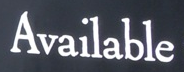

In [145]:
Image.open('demo.png')

## output of lstm after embedding:

In [ ]:
# layer_index = 0
# cnn_out = model.cnn(image)
# print('cnn shape:')
# print(cnn_out.shape)
# ## before the linear embedding step:
# lstm_before_embedding = model.rnn[layer_index].rnn
# b, c, h, w = cnn_out.size()
# assert h == 1, "the height of conv must be 1"
# cnn_out = cnn_out.squeeze(2)
# cnn_out = cnn_out.permute(2, 0, 1)  # [w, b, c]

# all_hidden_states, (last_hidden, last_cell) = lstm_before_embedding(cnn_out)
# # last_hidden.shape: [2, 1, 256]
# # last_cell.shape: [2, 1, 256]
# # all_hidden_states.shape: [26, 1, 512]

## output of lstm after embedding:

In [146]:
layer_index = 0
print(image.shape)

activation = {}
def get_activation(name):
    def hook(model, input, output):
      activation[name] = output.detach()
      handle.remove()
    return hook
# register the forward hook
handle = model.rnn[layer_index].embedding.register_forward_hook(get_activation('encoder_queried_layer'))
# pass some data through the model
output = model(image)
layer_out = activation['encoder_queried_layer'] 
handle.remove()
print(layer_out)

# https://discuss.pytorch.org/t/understanding-output-of-lstm/12320
# https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#torch.nn.LSTM
# https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm

cnn_out = model.cnn(image)
print('cnn shape:')
print(cnn_out.shape)
lstm = model.rnn[layer_index]
b, c, h, w = cnn_out.size()
assert h == 1, "the height of conv must be 1"
cnn_out = cnn_out.squeeze(2)
cnn_out = cnn_out.permute(2, 0, 1)  # [w, b, c]

# all_hidden_states, (last_hidden, last_cell) = lstm(cnn_out)
print(lstm(cnn_out))
handle.remove()

torch.Size([1, 1, 32, 100])
tensor([[ 0.1459, -0.0319, -0.1828,  ...,  0.3375,  0.4422,  0.4534],
        [ 1.0194,  0.0322,  0.1766,  ...,  0.2123,  0.8731,  0.2730],
        [ 1.0892, -0.0939,  0.2474,  ...,  0.0105,  0.9192,  0.1491],
        ...,
        [ 0.1243, -0.1776, -0.5460,  ...,  0.3503,  0.0951,  0.3460],
        [-0.1273,  0.3213, -0.1474,  ...,  0.3679, -0.0801,  0.4843],
        [-0.1736,  0.2214, -0.1007,  ...,  0.3807, -0.2407,  0.3881]],
       device='cuda:0')
cnn shape:
torch.Size([1, 512, 1, 26])
tensor([[[ 0.1459, -0.0319, -0.1828,  ...,  0.3375,  0.4422,  0.4534]],

        [[ 1.0194,  0.0322,  0.1766,  ...,  0.2123,  0.8731,  0.2730]],

        [[ 1.0892, -0.0939,  0.2474,  ...,  0.0105,  0.9192,  0.1491]],

        ...,

        [[ 0.1243, -0.1776, -0.5460,  ...,  0.3503,  0.0951,  0.3460]],

        [[-0.1273,  0.3213, -0.1474,  ...,  0.3679, -0.0801,  0.4843]],

        [[-0.1736,  0.2214, -0.1007,  ...,  0.3807, -0.2407,  0.3881]]],
       device='cuda:0',

In [168]:
layer_out.shape

torch.Size([26, 256])

In [155]:
handle.remove()

In [156]:
image.shape

torch.Size([1, 1, 32, 100])

In [157]:
preds = model(image)
print(preds.shape)

torch.Size([26, 1, 37])


In [159]:
type(preds)

torch.Tensor

In [160]:
_, preds = preds.max(2)
preds.shape

torch.Size([26, 1])

In [161]:
preds = preds.transpose(1, 0).contiguous().view(-1)
preds

tensor([11,  0,  0,  0,  0,  0, 32,  0,  0, 11,  0, 19,  0, 22,  0, 11,  0, 12,
        12,  0, 22,  0, 15,  0,  0,  0], device='cuda:0')

In [162]:
preds_size = Variable(torch.IntTensor([preds.size(0)]))
raw_pred = converter.decode(preds.data, preds_size.data, raw=True)
sim_pred = converter.decode(preds.data, preds_size.data, raw=False)
print('%-20s => %-20s' % (raw_pred, sim_pred))

a-----v--a-i-l-a-bb-l-e--- => available           


# Create 2D tensor:

In [11]:
def apply_all_shifts(im, shift_step):
    '''
    arg(s): 
        DEBUG NOTE: PYTORCH IS (#channels, rows, cols)!!
        im, an image of shape (3, im_size, im_size)
    return: 
        im_all_shifts, a list of all shifted images from the input image
        n_shifts, number of shifted images
    '''
    # im is of shape (1, 32, 100)

    ## vertical size might not be the same as the horizontal, note that the channel for tf and pytorch are in different dimension
    im_size_vertical = im.shape[1]
    im_size_horizontal = im.shape[2]
    
    n_shifts_vertical = int(math.ceil(im_size_vertical/ shift_step))
    n_shifts_horizontal = int(math.ceil(im_size_horizontal/ shift_step))
    n_shifts = n_shifts_vertical * n_shifts_horizontal 

    im_all_shifts = []
    # start with the unshifted im
    im_shift = im
    # im_all_shifts.append(np.expand_dims(im_shift,axis=0))
    for i in range(n_shifts_vertical):
        ## for pytorch axis = 1, for tensorflow axis = 0
        im_shift = np.roll(im_shift, shift = shift_step, axis=1)
        im_all_shifts.append(np.expand_dims(im_shift,axis=0))
        for j in range(n_shifts_horizontal):
            ## for pytorch axis = 2, for tensorflow axis = 1
            im_shift = np.roll(im_shift, shift = shift_step, axis=2)
            im_all_shifts.append(np.expand_dims(im_shift,axis=0))
          
    im_all_shifts = np.stack( im_all_shifts, axis=0 )
    im_all_shifts = torch.cuda.FloatTensor(im_all_shifts)
    return im_all_shifts, n_shifts

In [182]:
def compute_neuron_output(model, block,  layer_index, im_all_shifts,  max_indices = None, n_max_feature_maps = 500, plot_activity = False):

    '''
    arg(s):
        layer_names: list of strings indicating the names of the layers we want to take neuron outputs from
        im_all_shifts: all shifts of one particular image in the for loop
    return:
        
    '''
    print("im_all_shifts shape: ")
    print(im_all_shifts.shape)
    n_shifts = im_all_shifts.shape[0]
    neuron_output_highest = []
    im_all_shifts = torch.cuda.FloatTensor(im_all_shifts)

    neuron_output = []
    # go through all the batches in the dataset
    if block == 'RNN':
      for i in range(n_shifts):
      # forward pass -- getting the outputs
        image = im_all_shifts[i]

        # https://discuss.pytorch.org/t/understanding-output-of-lstm/12320
        # https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#torch.nn.LSTM
        # https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm

        activation = {}
        def get_activation(name):
            def hook(model, input, output):
              activation[name] = output.detach()
              handle.remove()
            return hook
        # register the forward hook
        handle = model.rnn[layer_index].embedding.register_forward_hook(get_activation('encoder_queried_layer'))
        # pass some data through the model
        output = model(image)
        layer_out = activation['encoder_queried_layer'] 
        handle.remove()
        neuron_output.append(layer_out.cpu().data)
      handle.remove()
      neuron_output = np.stack( neuron_output, axis=0 )
      print("neuron_output shape: ")
      print(neuron_output.shape)
      n_shifts, n_features, n_neurons =  neuron_output.shape
      ## the shape of neuron_output_by_fm is (n_shifts, n_feature_maps, #neurons)
      neuron_output_by_fm = neuron_output
    ## --- END OF RNN ---

    if block == 'CNN':
      for i in range(n_shifts):
      # forward pass -- getting the outputs
        image = im_all_shifts[i]
        
        activation = {}
        def get_activation(name):
            def hook(model, input, output):
              activation[name] = output.detach()
              handle.remove()
            return hook
        # register the forward hook
        handle = model.cnn.relu0.register_forward_hook(get_activation('encoder_queried_layer'))
        # pass some data through the model
        output = model(image)
        layer_out = activation['encoder_queried_layer'] 
        handle.remove()

        layer_out = layer_out.cpu().data
        neuron_output.append(layer_out.squeeze(dim=0))
      neuron_output = np.stack( neuron_output, axis=0 )
      print("neuron_output shape: ")
      print(neuron_output.shape)
      n_shifts, n_features, n_rows, n_cols =  neuron_output.shape
      n_neurons = n_rows * n_cols
      ## the shape of neuron_output_by_fm is (n_shifts, n_feature_maps, #neurons)
      neuron_output_by_fm = neuron_output.reshape((n_shifts,n_features,n_rows*n_cols))
    ## --- END OF CNN ---

    ## compute avg neuron firing rate in each feature map
    ## fm_avg is of shape (n_shifts, n_feature_maps)
    fm_avg = neuron_output_by_fm.sum(axis=2) / neuron_output_by_fm.shape[2]

    # if plot_activity == True:
    #     print("Indices of FM with highest average firing rate in response to each image: " )
    #     max_fm_ind = np.argmax(fm_avg,axis = 1)
    #     print(max_fm_ind)
    #     print("#neurons in the FM with highest average firing rate: " + str(n_neurons))
    #     # for f_i in range(n_features):
    #     #   plt.plot(fm_avg[:,f_i]/max(fm_avg[:,f_i]))
    #     plt.plot(fm_avg[:,0]/max(fm_avg[:,0]))
    #     plt.show()
    #     print('----------------------------------------------------\n')

    # neuron_output_highest = neuron_output_by_fm.reshape((n_shifts, n_features * n_neurons))
    
    neuron_output_highest = np.empty((n_shifts, n_max_feature_maps * n_neurons))

    for i in range(n_shifts):
        if max_indices is None:
            ## get the max magnitude (most negative and most positive firing)
            max_indices = np.argsort(-1*abs(fm_avg[i]))[:n_max_feature_maps]
        neuron_output_highest[i] = neuron_output_by_fm[i, max_indices, :].reshape((1, n_max_feature_maps * n_neurons))

        for f_i in range(n_max_feature_maps):
          normalizing_constant = abs(neuron_output_highest[i, (f_i*n_neurons):((f_i+1)*n_neurons)]).max()

          if normalizing_constant == 0:
            neuron_output_highest[i, (f_i*n_neurons):((f_i+1)*n_neurons)] = 0
          else:
            neuron_output_highest[i, (f_i*n_neurons):((f_i+1)*n_neurons)] /= normalizing_constant

    # if plot_activity == True:
    #     neuron_output_highest_by_fm = neuron_output_highest.reshape((n_shifts, n_max_feature_maps, n_neurons))
    #     fm_avg = neuron_output_highest_by_fm.sum(axis=2) / neuron_output_highest_by_fm.shape[2]

    #     print("Indices of FM with highest average firing rate in response to each image: " )
    #     max_fm_ind = np.argmax(fm_avg,axis = 1)
    #     print(max_fm_ind)
    #     print("#neurons in the FM with highest average firing rate: " + str(n_neurons))
    #     for f_i in range(n_max_feature_maps):
    #       plt.plot(fm_avg[:,f_i])
    #     plt.show()
    #     print('----------------------------------------------------\n')

    neuron_labels = []
    for i in range(n_max_feature_maps):
      neuron_labels += [i] * n_neurons
    neuron_labels = np.array(neuron_labels) 

    return neuron_output_highest, fm_avg, neuron_labels, max_indices, n_neurons

In [183]:
def show_stimuli_2D(model, block, layer_index, images_selected_classes, shifts, max_indices, n_images_selected_classes, shift_step = 3, n_max_feature_maps = 5, plot_activity = False):
    '''
    arg(s): 
        layer_indices, interested layers
        images_selected_classes, all the selected images
        shifts = True/False
    return:
        neuron_output_shifts_avg, (n_images, n_neurons)
    '''


    if shifts is False:
        neuron_output_highest_final, fm_avg_all_layers, neuron_labels, max_indices, n_neurons = compute_neuron_output(
            model, block, layer_index, images_selected_classes, max_indices, n_max_feature_maps, plot_activity) 
  
  
    else: 
        # generate shifts for each selected image and then stack: 
        neuron_output_highest_with_shifts = []
        for i in range(n_images_selected_classes):
            im = images_selected_classes[i]
            im_all_shifts, n_shifts =  apply_all_shifts(im, shift_step)
            
            ## neuron_output_highest is of shape (n_shifts, n_neurons * n_max_feature_maps)
            neuron_output_highest, fm_avg_all_layers, neuron_labels, max_indices, n_neurons = compute_neuron_output(
                model, block, layer_index, im_all_shifts, max_indices, n_max_feature_maps, plot_activity) 
  

            ## take the average over all shifts of im
            neuron_output_highest_shifts_avg = neuron_output_highest.sum(axis=0) / neuron_output_highest.shape[0] 
            neuron_output_highest_shifts_avg = neuron_output_highest_shifts_avg.reshape((1, neuron_output_highest_shifts_avg.shape[0]))


            fm_shifts_avg = fm_avg_all_layers.sum(axis=0) / fm_avg_all_layers.shape[0]
            fm_shifts_avg = fm_shifts_avg.reshape((1,fm_shifts_avg.shape[0]))
            
            if i == 0:
              neuron_output_highest_with_shifts = neuron_output_highest_shifts_avg 
              fm_avg_all_layers_with_shifts = fm_shifts_avg
            else:
              neuron_output_highest_with_shifts = np.vstack((neuron_output_highest_with_shifts, neuron_output_highest_shifts_avg))
              fm_avg_all_layers_with_shifts = np.vstack((fm_avg_all_layers_with_shifts, fm_shifts_avg))
        
        ## out of for loop!      
        ## neuron_output_highest_with_shifts is of shape (n_images_selected_classes, n_neurons * n_max_feature_maps)
        neuron_output_highest_with_shifts = np.array(neuron_output_highest_with_shifts)
        neuron_output_highest_final = neuron_output_highest_with_shifts
        fm_avg_all_layers = fm_avg_all_layers_with_shifts
 
    return neuron_output_highest_final, fm_avg_all_layers, neuron_labels, max_indices

In [184]:
neuron_output_highest_with_shifts, fm_avg, neuron_labels, max_indices = show_stimuli_2D(
    model, 'RNN', 0, images_selected_classes, shifts = True,  max_indices = None, n_images_selected_classes = num_images, n_max_feature_maps=20, plot_activity = False)

im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 26, 256)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 26, 256)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 26, 256)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 26, 256)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 26, 256)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 26, 256)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 26, 256)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 26, 256)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 26, 256)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 26, 256)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(38

In [185]:
data = np.transpose(neuron_output_highest_with_shifts, (1,0))
from scipy.io import savemat
mdic = {"neuron_output_2D": data}
mdic
savemat("neuron_output_2D_crnn.mat", mdic)

In [186]:
data.shape

(5120, 20)

# Tensor factorization:

In [187]:
N_crnn_2D = loadmat("neuron_output_2D_crnn.mat")["neuron_output_2D"]

In [188]:
!pip install git+https://github.com/ahwillia/tensortools
import tensortools as tt

  Cloning https://github.com/ahwillia/tensortools to /tmp/pip-req-build-yhg1a1f8
  Running command git clone -q https://github.com/ahwillia/tensortools /tmp/pip-req-build-yhg1a1f8


In [189]:
def get_tensor_factors(N, dim = 3, ranks = [10, 20, 30], reps = 1):
## note that for 2D tensor (ie a matrix), rank + nullity = num_columns => rank <= num_columns
  if dim == 3:
    N_filtered = N 
    # N_filtered = np.empty(N.shape)
    # for i in range(N.shape[0]):
    #   for j in range(N.shape[1]):
    #     filtered = gaussian_filter(N[i,j,:].reshape((n_vertical_shifts, n_vertical_shifts)), sigma=1).reshape((n_vertical_shifts * n_vertical_shifts,))
    #     N_filtered[i,j,:] = filtered[:]
  else:
    N_filtered = N.reshape((N.shape[0], N.shape[1],1))

  # Fit ensembles of tensor decompositions:
  methods = (
    "cp_als",  # Fits CP Decomposition using Alternating Least Squares (ALS).
  )

  ensembles = {}
  for m in methods:
      ensembles[m] = tt.Ensemble(fit_method=m,  fit_options=dict(tol=1e-5))
      ensembles[m].fit(N_filtered, ranks=ranks, replicates=reps)
      ## replicates: int, number of models to fit at each rank

  ## plot objective, similarity, factors:
  """
  Customized plotting routines for CP decompositions
  """

  # Plotting options for the unconstrained and nonnegative models.
  plot_options = {
    'cp_als': {
      'line_kw': {
        'color': 'blue',
        'alpha': 1,
        'label': 'cp_als',
      },
      'scatter_kw': {
        'color': 'blue',
        'alpha': 1,
        's': 1,
      },
    },
  }

  def plot_objective(ensemble, partition='train', ax=None, jitter=0.1,
                    scatter_kw=dict(), line_kw=dict()):
      """Plots objective function as a function of model rank.
      Parameters
      ----------
      ensemble : Ensemble object
          holds optimization results across a range of model ranks
      partition : string, one of: {'train', 'test'}
          specifies whether to plot the objective function on the training
          data or the held-out test set.
      ax : matplotlib axis (optional)
          axis to plot on (defaults to current axis object)
      jitter : float (optional)
          amount of horizontal jitter added to scatterpoints (default=0.1)
      scatter_kw : dict (optional)
          keyword arguments for styling the scatterpoints
      line_kw : dict (optional)
          keyword arguments for styling the line
      """

      if ax is None:
          ax = plt.gca()

      if partition == 'train':
          pass
      elif partition == 'test':
          raise NotImplementedError('Cross-validation is on the TODO list.')
      else:
          raise ValueError("partition must be 'train' or 'test'.")

      # compile statistics for plotting
      x, obj, min_obj = [], [], []
      for rank in sorted(ensemble.results):
          # reconstruction errors for rank-r models
          o = ensemble.objectives(rank)
          obj.extend(o)
          x.extend(np.full(len(o), rank))
          min_obj.append(min(o))

      print(o)
      print(obj)
      print(x)
      # add horizontal jitter
      ux = np.unique(x)
      x = np.array(x) + (np.random.rand(len(x))-0.5)*jitter

      # make plot
      # customized: plot objectives for all iterations
      ax.scatter(x, obj, **scatter_kw)
      ax.plot(ux, min_obj, **line_kw)
      ax.set_xlabel('model rank')
      ax.set_ylabel('objective')

      return ax


  def plot_similarity(ensemble, ax=None, jitter=0.1,
                      scatter_kw=dict(), line_kw=dict()):
      """Plots similarity across optimization runs as a function of model rank.
      Parameters
      ----------
      ensemble : Ensemble object
          holds optimization results across a range of model ranks
      ax : matplotlib axis (optional)
          axis to plot on (defaults to current axis object)
      jitter : float (optional)
          amount of horizontal jitter added to scatterpoints (default=0.1)
      scatter_kw : dict (optional)
          keyword arguments for styling the scatterpoints
      line_kw : dict (optional)
          keyword arguments for styling the line
      References
      ----------
      Ulrike von Luxburg (2010). Clustering Stability: An Overview.
      Foundations and Trends in Machine Learning.
      https://arxiv.org/abs/1007.1075
      """

      if ax is None:
          ax = plt.gca()

      # compile statistics for plotting
      x, sim, mean_sim = [], [], []
      for rank in sorted(ensemble.results):
          # reconstruction errors for rank-r models
          s = ensemble.similarities(rank)[1:]
          sim.extend(s)
          x.extend(np.full(len(s), rank))
          mean_sim.append(np.mean(s))

      # add horizontal jitter
      ux = np.unique(x)
      x = np.array(x) + (np.random.rand(len(x))-0.5)*jitter

      # make plot
      # customized: plot similarities for all iterations
      ax.scatter(x, sim, **scatter_kw)
      ax.plot(ux, mean_sim, **line_kw)

      ax.set_xlabel('model rank')
      ax.set_ylabel('model similarity')
      ax.set_ylim([0, 1.1])

      return ax

  # Plot similarity and error plots.
  plt.figure()
  for m in methods:
      plot_objective(ensembles[m], **plot_options[m])
  plt.legend()

  # plt.figure()
  # for m in methods:
  #     plot_similarity(ensembles[m], **plot_options[m])
  # plt.legend()

  plt.show()

  return ensembles ## A LIST!

In [190]:
def get_embeddings(tensor_factors_best_rank,neuron_labels,n_dim_PCA = 10): 
  neuron_factor = tensor_factors_best_rank[0]
  # PCA on tensor factors 
  pca = PCA(n_dim_PCA)
  neuron_output_highest_with_shifts_PCA = pca.fit_transform(neuron_factor)
  vectors, lambdas = pca.components_, pca.explained_variance_
  plt.plot(pca.explained_variance_ratio_)
  plt.show()

  # plot embeddings:
  data = neuron_output_highest_with_shifts_PCA
  import plotly.graph_objects as go
  import plotly.express as px

  fig = go.Figure()
  traces = []
  colors_palette = px.colors.qualitative.Dark24
  data = neuron_output_highest_with_shifts_PCA
  print(data.shape)
  for i, label in enumerate(set(neuron_labels)):
      mask = (neuron_labels == label)
      print(mask.shape)
      print(label, sum(mask))
      traces.append(go.Scatter3d(
          x=data[mask,0],
          y=data[mask,1],
          z=data[mask,2],
          mode='markers',
          marker=dict(
              size=4,
              color=colors_palette[int(label)],
              opacity=1,
              #showscale= True,
          )))

  for trace in traces:
      fig.add_trace(trace)
  fig.update_layout(
    
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

  fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,
                    # scene = dict(xaxis = dict(range=[-1.5,2.5],),
                    #              yaxis = dict(range=[-1.5,1.5],),
                    #              zaxis = dict(range=[-1.5,1.5],),),
                    )
  fig.show()
  return neuron_output_highest_with_shifts_PCA

In [191]:
def colorFromUnivariateData(Z1, cmap1 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)

    # Color for each point
    Z_color = np.array(Z1_color[:,0:3])
    return Z_color

## ## https://stackoverflow.com/questions/49871436/scatterplot-with-continuous-bivariate-color-palette-in-python

def colorFromBivariateData(Z1,Z2,cmap1 = plt.cm.Blues, cmap2 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)
    Z2_plot = np.array(255*(Z2-Z2.min())/(Z2.max()-Z2.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)
    Z2_color = cmap2(Z2_plot)

    # Color for each point
    Z_color = np.sum([Z1_color , Z2_color ], axis=0)/2.0
    Z_color = np.array(Z_color[:,0:3])
    return Z_color

def get_spatial_order_plot(cluster_index, neuron_output_highest_with_shifts_PCA, neuron_labels):
  n_neurons = int(neuron_labels.shape[0])
  feature_map_side = int(np.sqrt(n_neurons))
  neuron_cluster = neuron_output_highest_with_shifts_PCA[cluster_index * n_neurons : (cluster_index + 1) * n_neurons]
  neuron_labels_cluster = neuron_labels[cluster_index * n_neurons : (cluster_index + 1) * n_neurons]
  xs, ys = np.mgrid[0:feature_map_side,0:feature_map_side]
  xs = xs.reshape((n_neurons,))
  ys = ys.reshape((n_neurons,))

  import plotly.graph_objects as go
  import plotly.express as px

  fig = go.Figure()
  traces = []
  colors_palette = px.colors.qualitative.Dark24
  data = neuron_cluster

  for i, label in enumerate(set(neuron_labels)):
      mask = (neuron_labels_cluster == label)
      print(label, sum(mask))
      traces.append(go.Scatter3d(
          x=data[mask,0],
          y=data[mask,1],
          z=data[mask,2],
          mode='markers',
          marker=dict(
              size=4,
              color=colors_palette[int(label)],
              opacity=1,
              #showscale= True,
          )))
  for trace in traces:
      fig.add_trace(trace)
  fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
  fig.show()

  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(projection='3d')
  data = neuron_cluster
  ax.scatter(
          data[:,0],
          data[:,1],
          data[:,2],
          c = colorFromUnivariateData(xs, cmap1 = plt.cm.Blues),
          s = 100,
          alpha= 1
          ) 
  plt.show()

  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(projection='3d')
  data = neuron_cluster
  ax.scatter(
          data[:,0],
          data[:,1],
          data[:,2],
          c = colorFromUnivariateData(ys, cmap1 = plt.cm.Reds),
          s = 100,
          alpha= 1
          ) 
  plt.show()

In [192]:
def get_spatial_order_plot_2D(cluster_index, neuron_output_highest_with_shifts_PCA, neuron_labels, n_max_feature_maps=10):
  n_neurons = int(neuron_labels.shape[0]/n_max_feature_maps)
  neuron_cluster = neuron_output_highest_with_shifts_PCA[cluster_index * n_neurons : (cluster_index + 1) * n_neurons]
  neuron_labels_cluster = neuron_labels[cluster_index * n_neurons : (cluster_index + 1) * n_neurons]
  feature_map_side = int(np.sqrt(n_neurons))
  xs, ys = np.mgrid[0:feature_map_side,0:feature_map_side]
  xs = xs.reshape((n_neurons,))
  ys = ys.reshape((n_neurons,))

  import plotly.graph_objects as go
  import plotly.express as px

  fig = go.Figure()
  traces = []
  colors_palette = px.colors.qualitative.Dark24
  data = neuron_cluster

  for i, label in enumerate(set(neuron_labels)):
      mask = (neuron_labels_cluster == label)
      print(label, sum(mask))
      traces.append(go.Scatter(
          x=data[mask,0],
          y=data[mask,1],
          mode='markers',
          marker=dict(
              size=4,
              color=colors_palette[int(label)],
              opacity=1,
              #showscale= True,
          )))
  for trace in traces:
      fig.add_trace(trace)
  fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
  fig.show()

  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(projection='3d')
  data = neuron_cluster
  ax.scatter(
          data[:,0],
          data[:,1],
          c = colorFromUnivariateData(xs, cmap1 = plt.cm.Blues),
          s = 100,
          alpha= 1
          ) 
  plt.show()

  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(projection='3d')
  data = neuron_cluster
  ax.scatter(
          data[:,0],
          data[:,1],
          c = colorFromUnivariateData(ys, cmap1 = plt.cm.Reds),
          s = 100,
          alpha= 1
          ) 
  plt.show()

In [193]:
def get_tensor_factors_plot(tensor_factors_best_rank, best_rank, n_max_feature_maps):
  ## neuron_factor shape: (#neuron, #factors=best_rank)
  neuron_factor = tensor_factors_best_rank[0]
  ## neuron_factor shape: (#shifts, #factors=best_rank)
  time_factor = tensor_factors_best_rank[2]
  
  # neuron_factor_first = neuron_factor[:,0]
  plt.plot(neuron_factor)
  plt.show()
  
  # time_factor_first = time_factor[:,0]
  plt.plot(time_factor)
  plt.show()

  n_neurons = neuron_factor.shape[0]
  feature_map_side = int(np.sqrt(n_neurons/n_max_feature_maps))
  print(feature_map_side)
  for i in range(best_rank):
    neuron_factor_i_th = neuron_factor[:,i]
    vmin = neuron_factor_i_th.min()
    vmax = neuron_factor_i_th.max()
    f_i, axes = plt.subplots(1,n_max_feature_maps,figsize=(10,1))
    for f_i, ax in enumerate(axes):
      feature_map_matrix = neuron_factor_i_th[(f_i * feature_map_side ** 2): ((f_i+1) * feature_map_side ** 2)].reshape((feature_map_side, feature_map_side))
      ax.imshow(feature_map_matrix, vmin = vmin, vmax = vmax)
      ax.set(xticks = [], yticks = [])
    plt.show()

Rank-5 models:  min obj, 0.17;  max obj, 0.17;  time to fit, 0.5s


Rank-10 models:  min obj, 0.11;  max obj, 0.11;  time to fit, 0.4s


Rank-15 models:  min obj, 0.06;  max obj, 0.06;  time to fit, 0.6s


[0.06369182725552784]
[0.16940420101606246, 0.1083819542880391, 0.06369182725552784]
[5, 10, 15]


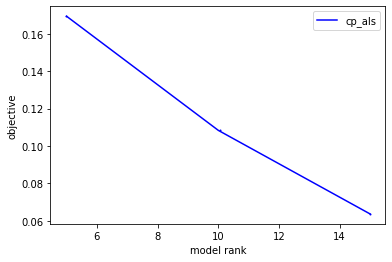

In [195]:
ensembles_2D = get_tensor_factors(N_crnn_2D, dim =2, ranks=[5,10,15])

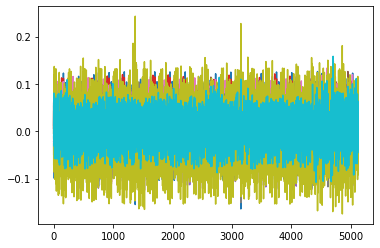

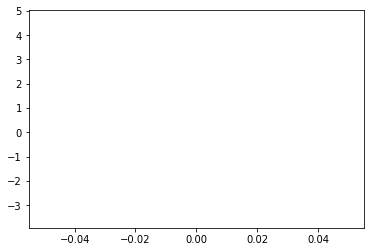

16


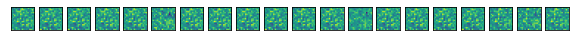

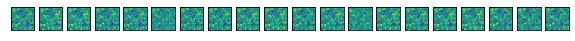

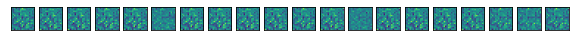

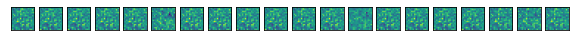

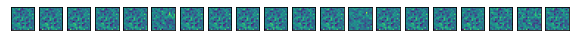

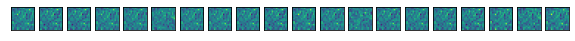

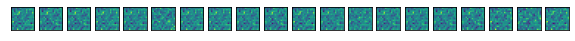

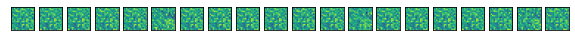

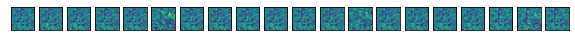

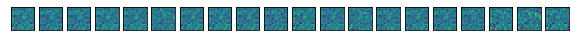

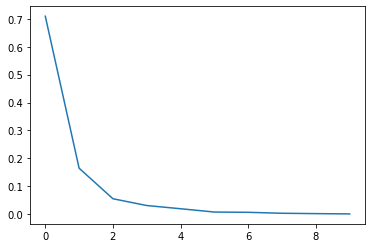

(5120, 10)
(5120,)
0 256
(5120,)
1 256
(5120,)
2 256
(5120,)
3 256
(5120,)
4 256
(5120,)
5 256
(5120,)
6 256
(5120,)
7 256
(5120,)
8 256
(5120,)
9 256
(5120,)
10 256
(5120,)
11 256
(5120,)
12 256
(5120,)
13 256
(5120,)
14 256
(5120,)
15 256
(5120,)
16 256
(5120,)
17 256
(5120,)
18 256
(5120,)
19 256


In [196]:
rep = 0
ranks = [10]
tensor_factors = []
for rank in ranks:
  tensor_factors.append(ensembles_2D['cp_als'].results[rank][rep].factors)
tensor_factors_best_rank = tensor_factors[0]

get_tensor_factors_plot(tensor_factors_best_rank, best_rank=10, n_max_feature_maps=20)
neuron_output_highest_with_shifts_PCA = get_embeddings(tensor_factors_best_rank, neuron_labels, n_dim_PCA = 10)
# get_spatial_order_plot(1, neuron_output_highest_with_shifts_PCA, neuron_labels)

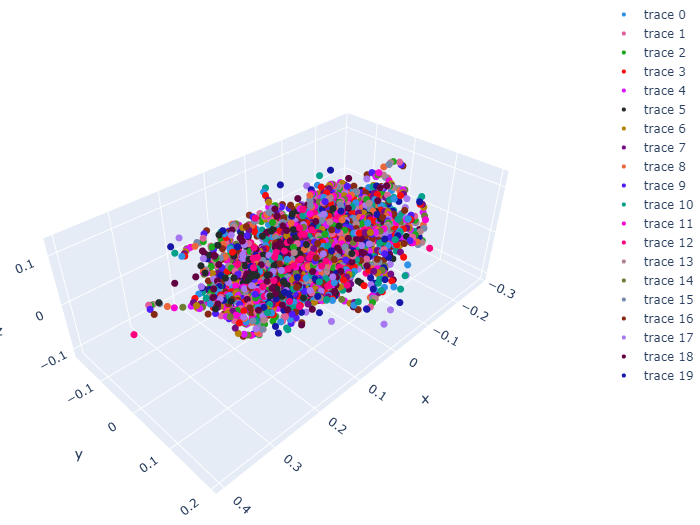

# Sanity check plot the CNN layer:

In [197]:
neuron_output_highest_with_shifts, fm_avg, neuron_labels, max_indices = show_stimuli_2D(
    model, 'CNN', 0, images_selected_classes, shifts = True,  max_indices = None, n_images_selected_classes = num_images, n_max_feature_maps=20, plot_activity = False)

im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 64, 32, 100)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 64, 32, 100)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 64, 32, 100)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 64, 32, 100)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 64, 32, 100)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 64, 32, 100)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 64, 32, 100)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 64, 32, 100)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 64, 32, 100)
im_all_shifts shape: 
torch.Size([385, 1, 1, 32, 100])
neuron_output shape: 
(385, 64, 32, 100)
im_all_shifts shape: 
torch.Size([385, 1

In [198]:
data = np.transpose(neuron_output_highest_with_shifts, (1,0))
from scipy.io import savemat
mdic = {"neuron_output_2D": data}
mdic
savemat("neuron_output_2D_cnn.mat", mdic)

In [199]:
data.shape

(64000, 20)

In [200]:
data.min()

0.0

In [201]:
N_cnn_2D = loadmat("neuron_output_2D_cnn.mat")["neuron_output_2D"]

In [202]:
def get_tensor_factors(N, dim = 3, ranks = [10, 20, 30], reps = 1):
## note that for 2D tensor (ie a matrix), rank + nullity = num_columns => rank <= num_columns
  if dim == 3:
    N_filtered = N 
    # N_filtered = np.empty(N.shape)
    # for i in range(N.shape[0]):
    #   for j in range(N.shape[1]):
    #     filtered = gaussian_filter(N[i,j,:].reshape((n_vertical_shifts, n_vertical_shifts)), sigma=1).reshape((n_vertical_shifts * n_vertical_shifts,))
    #     N_filtered[i,j,:] = filtered[:]
  else:
    N_filtered = N.reshape((N.shape[0], N.shape[1],1))

  # Fit ensembles of tensor decompositions:
  methods = (
    'ncp_hals',  # fits nonnegative tensor decomposition.
  )

  ensembles = {}
  for m in methods:
      ensembles[m] = tt.Ensemble(fit_method=m,  fit_options=dict(tol=1e-5))
      ensembles[m].fit(N_filtered, ranks=ranks, replicates=reps)
      ## replicates: int, number of models to fit at each rank

  ## plot objective, similarity, factors:
  """
  Customized plotting routines for CP decompositions
  """

  # Plotting options for the unconstrained and nonnegative models.
  plot_options = {
    'ncp_hals': {
      'line_kw': {
        'color': 'blue',
        'alpha': 1,
        'label': 'ncp_hals',
      },
      'scatter_kw': {
        'color': 'blue',
        'alpha': 1,
        's': 1,
      },
    },
  }

  def plot_objective(ensemble, partition='train', ax=None, jitter=0.1,
                    scatter_kw=dict(), line_kw=dict()):
      """Plots objective function as a function of model rank.
      Parameters
      ----------
      ensemble : Ensemble object
          holds optimization results across a range of model ranks
      partition : string, one of: {'train', 'test'}
          specifies whether to plot the objective function on the training
          data or the held-out test set.
      ax : matplotlib axis (optional)
          axis to plot on (defaults to current axis object)
      jitter : float (optional)
          amount of horizontal jitter added to scatterpoints (default=0.1)
      scatter_kw : dict (optional)
          keyword arguments for styling the scatterpoints
      line_kw : dict (optional)
          keyword arguments for styling the line
      """

      if ax is None:
          ax = plt.gca()

      if partition == 'train':
          pass
      elif partition == 'test':
          raise NotImplementedError('Cross-validation is on the TODO list.')
      else:
          raise ValueError("partition must be 'train' or 'test'.")

      # compile statistics for plotting
      x, obj, min_obj = [], [], []
      for rank in sorted(ensemble.results):
          # reconstruction errors for rank-r models
          o = ensemble.objectives(rank)
          obj.extend(o)
          x.extend(np.full(len(o), rank))
          min_obj.append(min(o))

      print(o)
      print(obj)
      print(x)
      # add horizontal jitter
      ux = np.unique(x)
      x = np.array(x) + (np.random.rand(len(x))-0.5)*jitter

      # make plot
      # customized: plot objectives for all iterations
      ax.scatter(x, obj, **scatter_kw)
      ax.plot(ux, min_obj, **line_kw)
      ax.set_xlabel('model rank')
      ax.set_ylabel('objective')

      return ax


  def plot_similarity(ensemble, ax=None, jitter=0.1,
                      scatter_kw=dict(), line_kw=dict()):
      """Plots similarity across optimization runs as a function of model rank.
      Parameters
      ----------
      ensemble : Ensemble object
          holds optimization results across a range of model ranks
      ax : matplotlib axis (optional)
          axis to plot on (defaults to current axis object)
      jitter : float (optional)
          amount of horizontal jitter added to scatterpoints (default=0.1)
      scatter_kw : dict (optional)
          keyword arguments for styling the scatterpoints
      line_kw : dict (optional)
          keyword arguments for styling the line
      References
      ----------
      Ulrike von Luxburg (2010). Clustering Stability: An Overview.
      Foundations and Trends in Machine Learning.
      https://arxiv.org/abs/1007.1075
      """

      if ax is None:
          ax = plt.gca()

      # compile statistics for plotting
      x, sim, mean_sim = [], [], []
      for rank in sorted(ensemble.results):
          # reconstruction errors for rank-r models
          s = ensemble.similarities(rank)[1:]
          sim.extend(s)
          x.extend(np.full(len(s), rank))
          mean_sim.append(np.mean(s))

      # add horizontal jitter
      ux = np.unique(x)
      x = np.array(x) + (np.random.rand(len(x))-0.5)*jitter

      # make plot
      # customized: plot similarities for all iterations
      ax.scatter(x, sim, **scatter_kw)
      ax.plot(ux, mean_sim, **line_kw)

      ax.set_xlabel('model rank')
      ax.set_ylabel('model similarity')
      ax.set_ylim([0, 1.1])

      return ax

  # Plot similarity and error plots.
  plt.figure()
  for m in methods:
      plot_objective(ensembles[m], **plot_options[m])
  plt.legend()

  # plt.figure()
  # for m in methods:
  #     plot_similarity(ensembles[m], **plot_options[m])
  # plt.legend()

  plt.show()

  return ensembles ## A LIST!

In [203]:
def get_embeddings(tensor_factors_best_rank,neuron_labels,n_dim_PCA = 10): 
  neuron_factor = tensor_factors_best_rank[0]
  # PCA on tensor factors 
  pca = PCA(n_dim_PCA)
  neuron_output_highest_with_shifts_PCA = pca.fit_transform(neuron_factor)
  vectors, lambdas = pca.components_, pca.explained_variance_
  plt.plot(pca.explained_variance_ratio_)
  plt.show()

  # plot embeddings:

  import plotly.graph_objects as go
  import plotly.express as px

  fig = go.Figure()
  traces = []
  colors_palette = px.colors.qualitative.Dark24
  data = neuron_output_highest_with_shifts_PCA
  print(data.shape)
  for i, label in enumerate(set(neuron_labels)):
      mask = (neuron_labels == label)
      print(mask.shape)
      print(label, sum(mask))
      traces.append(go.Scatter3d(
          x=data[mask,0],
          y=data[mask,1],
          z=data[mask,2],
          mode='markers',
          marker=dict(
              size=4,
              color=colors_palette[int(label)],
              opacity=1,
              #showscale= True,
          )))

  for trace in traces:
      fig.add_trace(trace)
  fig.update_layout(
    
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

  fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,
                    # scene = dict(xaxis = dict(range=[-1.5,2.5],),
                    #              yaxis = dict(range=[-1.5,1.5],),
                    #              zaxis = dict(range=[-1.5,1.5],),),
                    )
  fig.show()
  return neuron_output_highest_with_shifts_PCA

In [204]:
def get_tensor_factors_plot(tensor_factors_best_rank, best_rank, n_max_feature_maps):
  ## neuron_factor shape: (#neuron, #factors=best_rank)
  neuron_factor = tensor_factors_best_rank[0]
  ## neuron_factor shape: (#shifts, #factors=best_rank)
  time_factor = tensor_factors_best_rank[2]
  
  # neuron_factor_first = neuron_factor[:,0]
  plt.plot(neuron_factor)
  plt.show()
  
  # time_factor_first = time_factor[:,0]
  plt.plot(time_factor)
  plt.show()

  n_neurons = neuron_factor.shape[0]
  feature_map_side = int(np.sqrt(n_neurons/n_max_feature_maps))
  print(feature_map_side)
  for i in range(best_rank):
    neuron_factor_i_th = neuron_factor[:,i]
    vmin = neuron_factor_i_th.min()
    vmax = neuron_factor_i_th.max()
    f_i, axes = plt.subplots(1,n_max_feature_maps,figsize=(10,1))
    for f_i, ax in enumerate(axes):
      feature_map_matrix = neuron_factor_i_th[(f_i * feature_map_side ** 2): ((f_i+1) * feature_map_side ** 2)].reshape((feature_map_side, feature_map_side))
      ax.imshow(feature_map_matrix, vmin = vmin, vmax = vmax)
      ax.set(xticks = [], yticks = [])
    plt.show()

Fitting rank-5 models:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensortools/optimize/ncp_hals.py:185: NumbaPerformanceWarning:

'@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))

/usr/local/lib/python3.7/dist-packages/numba/core/typing/npydecl.py:930: NumbaPerformanceWarning:

'@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))

                                                                    

Rank-5 models:  min obj, 0.14;  max obj, 0.14;  time to fit, 7.6s


Rank-6 models:  min obj, 0.12;  max obj, 0.12;  time to fit, 11.4s


Rank-7 models:  min obj, 0.10;  max obj, 0.10;  time to fit, 36.3s


[0.10488064468615826]
[0.14057269116513924, 0.12052033711293705, 0.10488064468615826]
[5, 6, 7]


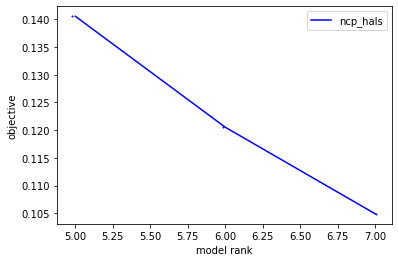

In [205]:
ensembles_2D = get_tensor_factors(N_cnn_2D, dim =2, ranks=[5,6,7])

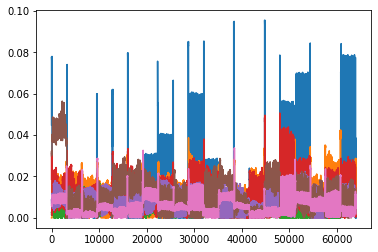

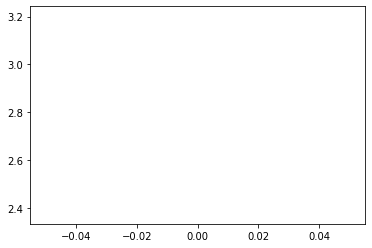

56


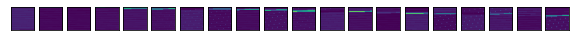

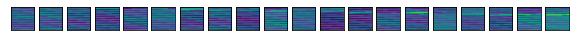

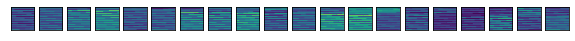

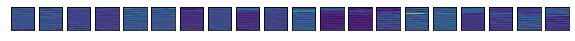

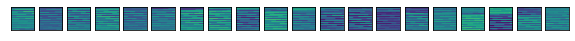

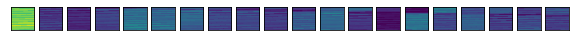

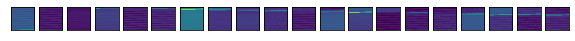

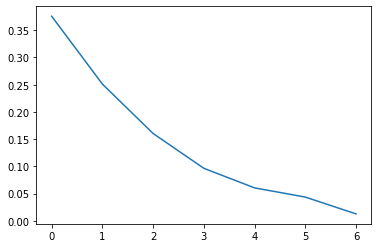

(64000, 7)
(64000,)
0 3200
(64000,)
1 3200
(64000,)
2 3200
(64000,)
3 3200
(64000,)
4 3200
(64000,)
5 3200
(64000,)
6 3200
(64000,)
7 3200
(64000,)
8 3200
(64000,)
9 3200
(64000,)
10 3200
(64000,)
11 3200
(64000,)
12 3200
(64000,)
13 3200
(64000,)
14 3200
(64000,)
15 3200
(64000,)
16 3200
(64000,)
17 3200
(64000,)
18 3200
(64000,)
19 3200


ValueError: ignored

In [207]:
rep = 0
ranks = [7]
tensor_factors = []
for rank in ranks:
  tensor_factors.append(ensembles_2D['ncp_hals'].results[rank][rep].factors)
tensor_factors_best_rank = tensor_factors[0]

get_tensor_factors_plot(tensor_factors_best_rank, best_rank=7, n_max_feature_maps=20)
neuron_output_highest_with_shifts_PCA = get_embeddings(tensor_factors_best_rank, neuron_labels, n_dim_PCA = 7)
get_spatial_order_plot(1, neuron_output_highest_with_shifts_PCA, neuron_labels)

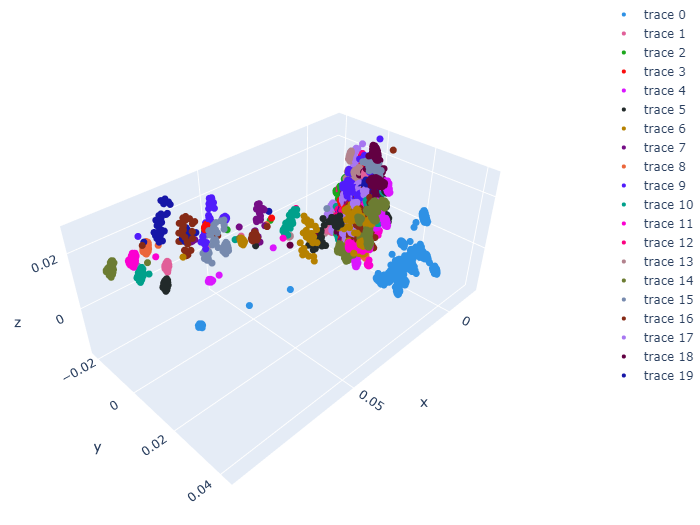